# Render paper plots and tables

In [1]:
import math
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

**Note:** _Change_ the following path to the aggregated results file in your local system 
(can be obtained using the `parse-acs-results.ipynb` notebook).

In [2]:
# ACS_AGG_RESULTS_PATH = Path("../results") / "aggregated-results.csv"
ACS_AGG_RESULTS_PATH = "/fast/groups/sf/folktexts-results/2024-08-28_2/aggregated_results.2024.08.29-15.34.22.csv"
ACS_AGG_RESULTS_PATH = Path(ACS_AGG_RESULTS_PATH)

In [3]:
results_df = pd.read_csv(ACS_AGG_RESULTS_PATH, index_col=0)
print(f"{results_df.shape=}")
results_df.head(2)

results_df.shape=(162, 63)


,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,name,is_inst,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean
penai/gpt-4o-mini__ACSTravelTime__-1__QA,0.550692,0.291667,0.562500,0.589535,0.473214,0.311688,0.406414,0.395482,0.39544,0.929545,...,GPT 4o mini (it),False,-1,True,0.997527,0.603736,0.977023,0.592009,0.364966,0.774507
penai/gpt-4o-mini__ACSTravelTime__-1__Num,0.570464,0.375000,0.571429,0.553396,0.140152,0.775758,0.268625,0.150667,NaN,0.554545,...,GPT 4o mini (it),False,-1,True,0.250000,0.506579,0.450000,0.570396,0.225674,0.385004


Remove `gemma-2-*` results (need to investigate why results are so poor):

In [4]:
results_df = results_df.drop(index=[id_ for id_ in results_df.index if "gemma-2-" in id_.lower()])
print(f"{results_df.shape=}")

results_df.shape=(125, 63)


## Run baseline ML classifiers on the benchmark ACS tasks

In [5]:
DATA_DIR = Path("/fast/groups/sf") / "data"

In [6]:
ALL_TASKS = [
    "ACSIncome",
    "ACSMobility",
    "ACSEmployment",
    "ACSTravelTime",
    "ACSPublicCoverage",
]

model_col = "config_model_name"
task_col = "config_task_name"
numeric_prompt_col = "config_numeric_risk_prompting"

List all baseline classifiers here:

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier    # NOTE: requires `pip install xgboost`

baselines = {
    "LR": LogisticRegression(),
    "GBM": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
}

In [8]:
from folktexts.acs.acs_dataset import ACSDataset
from folktexts.evaluation import evaluate_predictions
from collections import defaultdict

def fit_and_eval(
    clf,
    X_train, y_train,
    X_test, y_test, s_test,
    fillna=False,
    save_scores_df_path: str = None,
) -> dict:
    """Fit and evaluate a given classifier on the given data."""
    assert len(X_train) == len(y_train) and len(X_test) == len(y_test) == len(s_test)

    train_nan_count = X_train.isna().any(axis=1).sum()
    if fillna and train_nan_count > 0:
        # Fill NaNs with value=-1
        X_train = X_train.fillna(axis="columns", value=-1)
        X_test = X_test.fillna(axis="columns", value=-1)

    # Fit on train data
    clf.fit(X_train, y_train)

    # Evaluate on test data
    y_test_scores = clf.predict_proba(X_test)[:, -1]
    test_results = evaluate_predictions(
        y_true=y_test.to_numpy(),
        y_pred_scores=y_test_scores,
        sensitive_attribute=s_test,
        threshold=0.5,
    )

    # Optionally, save test scores DF
    if save_scores_df_path:
        scores_df = pd.DataFrame({
            "risk_score": y_test_scores,
            "label": y_test,
        })
        scores_df.to_csv(save_scores_df_path)
        test_results["predictions_path"] = save_scores_df_path

    return test_results

def run_baselines(baselines, tasks) -> dict:
    """Run baseline classifiers on all acs tasks."""
    baseline_results = defaultdict(dict)

    # Prepare progress bar
    progress_bar = tqdm(
        total=len(tasks) * len(baselines),
        leave=True,
    )

    for task in tasks:
        progress_bar.set_postfix({"task": task})

        # Load ACS task data
        acs_dataset = ACSDataset.make_from_task(task=task, cache_dir=DATA_DIR)
    
        # Get train/test data
        X_train, y_train = acs_dataset.get_train()
        X_test, y_test = acs_dataset.get_test()
    
        # Get sensitive attribute test data
        s_test = None
        if acs_dataset.task.sensitive_attribute is not None:
            s_test = acs_dataset.get_sensitive_attribute_data().loc[y_test.index]
    
        for clf_name, clf in baselines.items():
            progress_bar.set_postfix({"task": task, "clf": clf_name})

            try:
                baseline_results[task][clf_name] = fit_and_eval(
                    clf=clf,
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test, s_test=s_test,
                    fillna=(clf_name == "LR"),
                    save_scores_df_path=ACS_AGG_RESULTS_PATH.parent / f"baseline_scores.{clf_name}.{task}.csv"
                )
            except Exception as err:
                logging.error(err)
            finally:
                progress_bar.update()

    return baseline_results

Flatten results and add extra columns.

In [9]:
def parse_baseline_results(baseline_results) -> list:
    """Flatten and parse baseline results."""
    parsed_results_list = list()
    
    for task, task_results in baseline_results.items():
    
        for clf, clf_results in task_results.items():
            parsed_results = clf_results.copy()
    
            parsed_results["config_task_name"] = task
            parsed_results["config_model_name"] = clf
            parsed_results["name"] = clf
            parsed_results["num_features"] = -1
            parsed_results["uses_all_features"] = True
    
            parsed_results_list.append(parsed_results)

    return parsed_results_list

Check if baseline results were already computed. If so, load csv; otherwise, compute and save.

In [10]:
# BASELINE_RESULTS_PATH = ACS_AGG_RESULTS_PATH.parent / ("baseline-results." + ".".join(sorted(baselines.keys())) + ".csv")
BASELINE_RESULTS_PATH = Path("../results") / ("baseline-results." + ".".join(sorted(baselines.keys())) + ".csv")

# If saved results exists: load
if BASELINE_RESULTS_PATH.exists():
    print(f"Loading pre-computed baseline results from {BASELINE_RESULTS_PATH.as_posix()}")
    baselines_df = pd.read_csv(BASELINE_RESULTS_PATH, index_col=0)

# Compute baseline results
else:
    print(f"Computing baseline results and saving to {BASELINE_RESULTS_PATH.as_posix()}")
    # Compute baseline results
    baseline_results = run_baselines(baselines, tasks=ALL_TASKS)

    # Parse results
    parsed_results_list = parse_baseline_results(baseline_results)

    # Construct DF
    baselines_df = pd.DataFrame(parsed_results_list, index=[r["name"] for r in parsed_results_list])
    
    # Save DF to disk
    baselines_df.to_csv(BASELINE_RESULTS_PATH)

# Untie indices
baselines_df["new_index"] = [(r["name"] + "_" + r[task_col]) for _, r in baselines_df.iterrows()]
baselines_df = baselines_df.set_index("new_index", drop=True)

# Show 2 random rows
baselines_df.sample(2)

Loading pre-computed baseline results from ../results/baseline-results.GBM.LR.XGBoost.csv


,threshold,n_samples,n_positives,n_negatives,model_name,accuracy,tpr,fnr,fpr,tnr,...,equalized_odds_diff,roc_auc,ece,ece_quantile,predictions_path,config_task_name,config_model_name,name,num_features,uses_all_features
new_index,,,,,,,,,,,,,,,,,,,,,
GBM_ACSPublicCoverage,0.5,113829,33971,79858,NaN,0.797740,0.495687,0.504313,0.073768,0.926232,...,0.354062,0.833531,0.010786,0.010199,/fast/groups/sf/folktexts-results/2024-07-03/b...,ACSPublicCoverage,GBM,GBM,-1,True
LR_ACSMobility,0.5,62094,45648,16446,NaN,0.735643,0.982562,0.017438,0.949714,0.050286,...,0.100000,0.613910,0.015739,0.023017,/fast/groups/sf/folktexts-results/2024-07-03/b...,ACSMobility,LR,LR,-1,True


In [11]:
all_results_df = pd.concat((results_df, baselines_df))
print(f"{all_results_df.shape=}")

all_results_df.shape=(140, 63)


## Prepare results table for each task

In [12]:
table_metrics = ["ece", "brier_score_loss", "roc_auc", "accuracy", "fit_thresh_accuracy", "score_stdev"] #, "score_mean"]

Add model size and model family columns:

In [13]:
from folktexts.llm_utils import get_model_size_B

all_results_df["model_size"] = [
    (
        get_model_size_B(row["name"], default=float("nan"))
        if row["name"] not in baselines else "-"
    )
    for _, row in all_results_df.iterrows()
]

def get_model_family(model_name) -> str:
    if "gpt" in model_name.lower():
        return "OpenAI"
    elif "llama" in model_name.lower():
        return "Llama"
    elif "mistral" in model_name.lower() or "mixtral" in model_name.lower():
        return "Mistral"
    elif "gemma" in model_name.lower():
        return "Gemma"
    elif "yi" in model_name.lower():
        return "Yi"
    elif "qwen" in model_name.lower():
        return "Qwen"
    else:
        return "-"

all_results_df["model_family"] = [get_model_family(row[model_col]) for _, row in all_results_df.iterrows()]
all_results_df.groupby([task_col, "model_family"])["accuracy"].count()

config_task_name   model_family
ACSEmployment      -                3
                   Gemma            7
                   Mistral          9
                   OpenAI           2
                   Yi               2
ACSIncome          -                3
                   Gemma            8
                   Llama            2
                   Mistral         11
                   OpenAI           2
                   Yi               4
ACSMobility        -                3
                   Gemma            8
                   Llama            2
                   Mistral         12
                   OpenAI           2
                   Yi               4
ACSPublicCoverage  -                3
                   Gemma            8
                   Llama            1
                   Mistral         11
                   OpenAI           2
                   Yi               4
ACSTravelTime      -                3
                   Gemma            8
                  

In [14]:
def model_sort_key(name, task_df):
    """Sort key for paper table rows."""

    if "gpt" in name.lower():
        key = 11
    elif "llama" in name.lower():
        key = 10
    elif "mixtral" in name.lower():
        key = 9
    elif "mistral" in name.lower():
        key = 8
    elif "yi" in name.lower():
        key = 7
    elif "gemma" in name.lower():
        key = 6
    else:
        return 0

    row = task_df.loc[name]
    return (1e3 * key) + int(row["is_inst"] * 100) + (row["model_size"] * 10) + (5 if row[numeric_prompt_col] else 0)


In [15]:
def latex_colored_float_format(val, all_values, higher_is_better=True):
    """Map a cell's value to its colored latex code.

    Current definition:
    - use cyan color gradient for good values;
    - use orange color gradient for bad values;
    - use no color for anything in between;
    """
    min_val, max_val = np.min(all_values), np.max(all_values)

    low_pct_val, high_pct_val = [
        min_val + (max_val - min_val) * interp_point
        for interp_point in [0.1, 0.9]
    ]

    # Use rounded value or original value for coloring?
    # > Using rounded value for consistency in table
    # val = np.round(val, decimals=2)

    # Use no color for middle 33% of values
    if low_pct_val <= val <= high_pct_val:
        return f"{val:.2f}"

    if val < low_pct_val:
        color = "orange" if higher_is_better else "cyan"
        color_value = 100 * (
            (low_pct_val - val) / (low_pct_val - min_val))
        
    elif val > high_pct_val:
        color = "cyan" if higher_is_better else "orange"
        color_value = 100 * (
            (val - high_pct_val) / (max_val - high_pct_val))

    else:
        raise RuntimeError(f"{val}")

    # Note: halving `color_value` to have softer colors
    color_value /= 4

    return (
        r"\cellcolor{"
        + f"{color}!{color_value:.1f}"
        + r"} "
        + f"{val:.2f}"
    )

higher_is_better_cols = {"roc_auc", "accuracy", "fit_thresh_accuracy"}

## Output latex results tables - colored!

In [16]:
from utils import prettify_model_name

for task in ALL_TASKS:
    task_df = all_results_df[all_results_df[task_col] == task]

    # Sort table rows
    sorted_df_index = sorted(
        task_df.index.tolist(),
        key=lambda id_: model_sort_key(id_, task_df),
        reverse=True,
    )

    latex_tab_cols = [numeric_prompt_col] + table_metrics

    # latex_table = task_df.sort_values(["model_family", "model_size", "is_inst"], ascending=False).set_index(model_col)[table_metrics].round(3)
    latex_table = task_df.loc[sorted_df_index].set_index(model_col)[latex_tab_cols].round(3)
    latex_table = latex_table.fillna("-")

    # Prettify model names
    latex_table["Model"] = [
        prettify_model_name(id_) + (" (Num.)" if row[numeric_prompt_col] else " (Q\&A)") if id_ not in baselines.keys() else id_
        for id_, row in latex_table.iterrows()
    ]
    latex_table.set_index("Model", drop=True, inplace=True)

    for col in set(latex_table.columns.tolist()) - {"score_stdev", numeric_prompt_col, "model_family"}:
        index_without_baselines = [name for name in latex_table.index if name not in baselines]
        index_baselines = list(baselines.keys())

        col_data = latex_table.loc[index_without_baselines, col].copy()

        new_col_data = [
            latex_colored_float_format(
                val=col_data.loc[id_], all_values=col_data,
                higher_is_better=col in higher_is_better_cols,
            )
            for id_ in index_without_baselines
        ] + [
            latex_table.loc[id_, col]
            for id_ in index_baselines
        ]

        # Set compatible dtype
        latex_table = latex_table.astype({col: str})

        # Set new data
        latex_table.loc[index_without_baselines + index_baselines, col] = new_col_data


    print(f"*** {task.upper()} ***\n")
    print(latex_table.to_latex(float_format="%.2f"))
    print("")

*** ACSINCOME ***

\begin{tabular}{llllllll}
\toprule
 & config_numeric_risk_prompting & ece & brier_score_loss & roc_auc & accuracy & fit_thresh_accuracy & score_stdev \\
Model &  &  &  &  &  &  &  \\
\midrule
GPT 4o mini (it) (Q\&A) & False & 0.24 & 0.24 & \cellcolor{cyan!23.6} 0.85 & 0.74 & \cellcolor{cyan!1.4} 0.77 & 0.48 \\
GPT 4o mini (it) (Num.) & True & \cellcolor{cyan!25.0} 0.05 & \cellcolor{cyan!25.0} 0.16 & \cellcolor{cyan!10.3} 0.83 & \cellcolor{cyan!23.8} 0.78 & \cellcolor{cyan!14.5} 0.78 & 0.32 \\
Mixtral 8x22B (it) (Num.) & True & 0.11 & \cellcolor{cyan!20.2} 0.17 & \cellcolor{cyan!15.2} 0.84 & \cellcolor{cyan!16.5} 0.77 & \cellcolor{cyan!5.4} 0.77 & 0.30 \\
Mixtral 8x22B (it) (Q\&A) & False & 0.21 & 0.22 & \cellcolor{cyan!19.4} 0.85 & \cellcolor{cyan!11.7} 0.76 & 0.75 & 0.48 \\
Mixtral 8x22B (Q\&A) & False & 0.16 & \cellcolor{cyan!9.5} 0.19 & \cellcolor{cyan!22.2} 0.85 & 0.68 & \cellcolor{cyan!14.5} 0.78 & 0.10 \\
Llama 3 70B (Num.) & True & 0.21 & 0.21 & 0.82 & 0.54 & 

## Render paper plots

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={"grid.linestyle": "--"})
plt.rc("figure", figsize=(4.5, 3.5), dpi=200)

palette_name = "tab10"   # "colorblind"
palette = sns.color_palette(palette_name)
sns.set_palette(palette_name)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [18]:
IMGS_DIR = ACS_AGG_RESULTS_PATH.parent / "imgs"
IMGS_DIR.mkdir(exist_ok=True)

def save_fig(fig, name):
    fig.savefig((IMGS_DIR / name).with_suffix(".pdf"), bbox_inches="tight")

Load scores distributions for each model (and with varying degrees of information).

In [19]:
predictions_path_col = "predictions_path"

def load_model_scores_df(df_row: pd.Series) -> pd.DataFrame:
    """Loads csv containing model scores corresponding to the given DF row."""
    if predictions_path_col in df_row and not pd.isna(df_row[predictions_path_col]):
        return pd.read_csv(df_row[predictions_path_col], index_col=0)
    return None

In [20]:
scores_df_map = {
    id_: load_model_scores_df(row)
    for id_, row in tqdm(all_results_df.iterrows(), total=len(all_results_df))
}

  0%|          | 0/140 [00:00<?, ?it/s]

#### 1st page illustrative plot

In [59]:
example_task = "ACSIncome"

example_model = "Mistral-7B-v0.1"
# example_model = "Meta-Llama-3-70B"
# example_model = "penai/gpt-4o-mini"

example_uses_num_prompt = False
baseline_model = "XGBoost"

In [60]:
# Data for baseline model
baseline_row = all_results_df[(all_results_df["name"] == baseline_model) & (all_results_df[task_col] == example_task)].iloc[0]

# Data for base and instruct models
example_df = all_results_df[
    (all_results_df[task_col] == example_task)
    & (all_results_df["base_name"] == example_model)
    & (all_results_df[numeric_prompt_col] == example_uses_num_prompt)
]

# Sort examples_df to have (base, instruct) ordering
example_df = example_df.sort_values("is_inst", ascending=True)
example_df

,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean,model_size,model_family
Mistral-7B-v0.1__ACSIncome__-1__QA,0.730586,0.116849,0.859132,0.725933,0.090640,0.879273,0.231023,0.199313,NaN,0.374096,...,-1,True,0.515576,0.741135,0.484594,0.730568,0.036201,0.488838,7,Mistral
Mistral-7B-Instruct-v0.2__ACSIncome__-1__QA,0.768213,0.088087,0.895748,0.722281,0.209306,0.732232,0.218206,0.211363,NaN,0.559717,...,-1,True,0.000626,0.766194,0.000007,0.746759,0.423230,0.264562,7,Mistral


/tmp/ipykernel_1158418/1392915733.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["Base", "Instr."])
/tmp/ipykernel_1158418/1392915733.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(["Base", "Instr."])


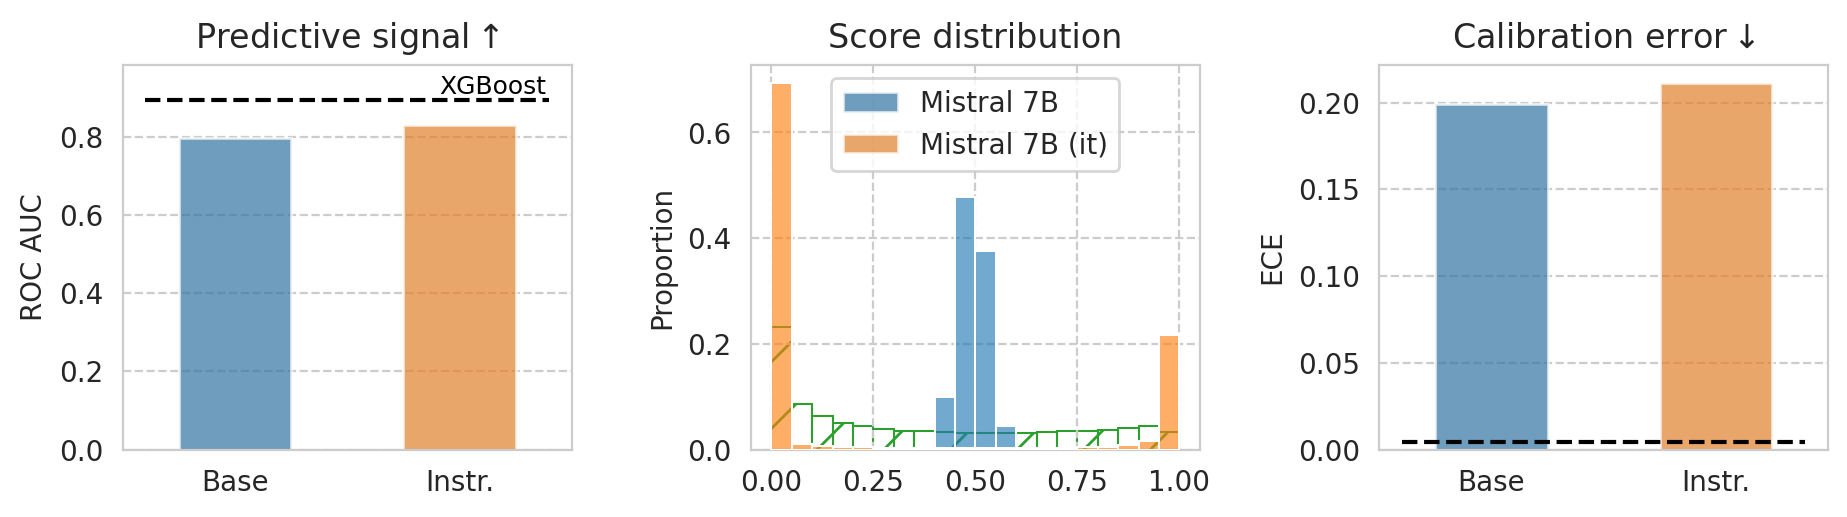

In [61]:
ALPHA = 0.7
N_BINS = 20

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(11, 2.5), gridspec_kw=dict(wspace=0.4))

###
# ROC barplot
###
sns.barplot(
    data=example_df,
    x="is_inst",
    y="roc_auc",
    hue="name",
    alpha=ALPHA,
    width=0.5,
    ax=ax1,
)

# Add horizontal line and label
ax1.axhline(y=baseline_row["roc_auc"], label=baseline_model, ls="--", color="black", xmin=0.05, xmax=0.95)
ax1.text(
    x=1.15,
    y=baseline_row["roc_auc"] + 1e-3,
    s=baseline_model,
    color="black",
    fontsize=9,
    ha='center',
    va='bottom',
    backgroundcolor='white',
    zorder=-1,
)

ax1.set_ylim(0, baseline_row["roc_auc"] + 9e-2)
# ax1.set_ylim(0.5, baseline_row["roc_auc"] + 7e-2)
ax1.set_ylabel("ROC AUC")
ax1.set_xlabel(None)
ax1.legend().remove()   # Remove the legend
ax1.set_xticklabels(["Base", "Instr."])
ax1.set_title("Predictive signal" + r"$\uparrow$")

###
# Score distribution
###
bins = np.histogram_bin_edges([], bins=N_BINS, range=(0, 1))
for id_ in example_df.index.tolist():
    sns.histplot(
        scores_df_map[id_]["risk_score"],
        alpha=ALPHA * 0.9,
        stat="proportion",
        bins=bins,
        zorder=100,
        ax=ax2,
    )

# Draw baseline score distribution
sns.histplot(
    scores_df_map[baseline_row.name]["risk_score"],
    alpha=1,
    bins=bins,
    stat="proportion",
    fill=False,
    color=palette[2],
    edgecolor=palette[2],
    hatch="/",
    zorder=-1,
    ax=ax2,
)

ax2.set_xlabel(None)
ax2.set_title("Score distribution")

###
# Calibration error
###
sns.barplot(
    data=example_df,
    x="is_inst",
    y="ece",
    hue="name",
    alpha=ALPHA,
    width=0.5,
    ax=ax3,
)

# Add horizontal line and label
ax3.axhline(y=baseline_row["ece"], label=baseline_model, ls="--", color="black", xmin=0.05, xmax=0.95)

ax3.set_ylabel("ECE")
ax3.set_xlabel(None)
ax3.set_xticklabels(["Base", "Instr."])
ax3.set_title("Calibration error" + "$\downarrow$")
# ax3.legend(
#     loc="center left",
#     bbox_to_anchor=(1.05, 0.5),
# )

hs, ls = ax3.get_legend_handles_labels()
ax3.legend().remove()
ax2.legend(handles=hs[:2], labels=ls[:2], loc="upper center")

save_fig(fig, f"teaser-{example_model}")

#### Score distributions for base/instruct pairs

In [62]:
print(f"Plotting score distributions for the following task: {example_task}.")

task_df = all_results_df[all_results_df[task_col] == example_task]
print(f"{len(task_df)=}")

Plotting score distributions for the following task: ACSIncome.
len(task_df)=30


Sort model pairs as wished for the paper plot:

In [63]:
sorted_model_families = ["Llama", "Mistral", "Yi", "Gemma", "-"]

model_pairs = sorted([
        (row["base_name"], row[model_col])
        for id_, row in task_df[task_df["is_inst"] == True].iterrows()
    ],
    key=lambda val: (
        1e6 * sorted_model_families.index((row := task_df[task_df[model_col] == val[0]].iloc[0])["model_family"])
        + row["model_size"]
    )
)
model_pairs

[('Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.2'),
 ('Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.2'),
 ('Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1'),
 ('Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1'),
 ('Mixtral-8x22B-v0.1', 'Mixtral-8x22B-Instruct-v0.1'),
 ('Mixtral-8x22B-v0.1', 'Mixtral-8x22B-Instruct-v0.1'),
 ('Yi-34B', 'Yi-34B-Chat'),
 ('Yi-34B', 'Yi-34B-Chat'),
 ('gemma-2b', 'gemma-1.1-2b-it'),
 ('gemma-2b', 'gemma-1.1-2b-it'),
 ('gemma-7b', 'gemma-1.1-7b-it'),
 ('gemma-7b', 'gemma-1.1-7b-it')]

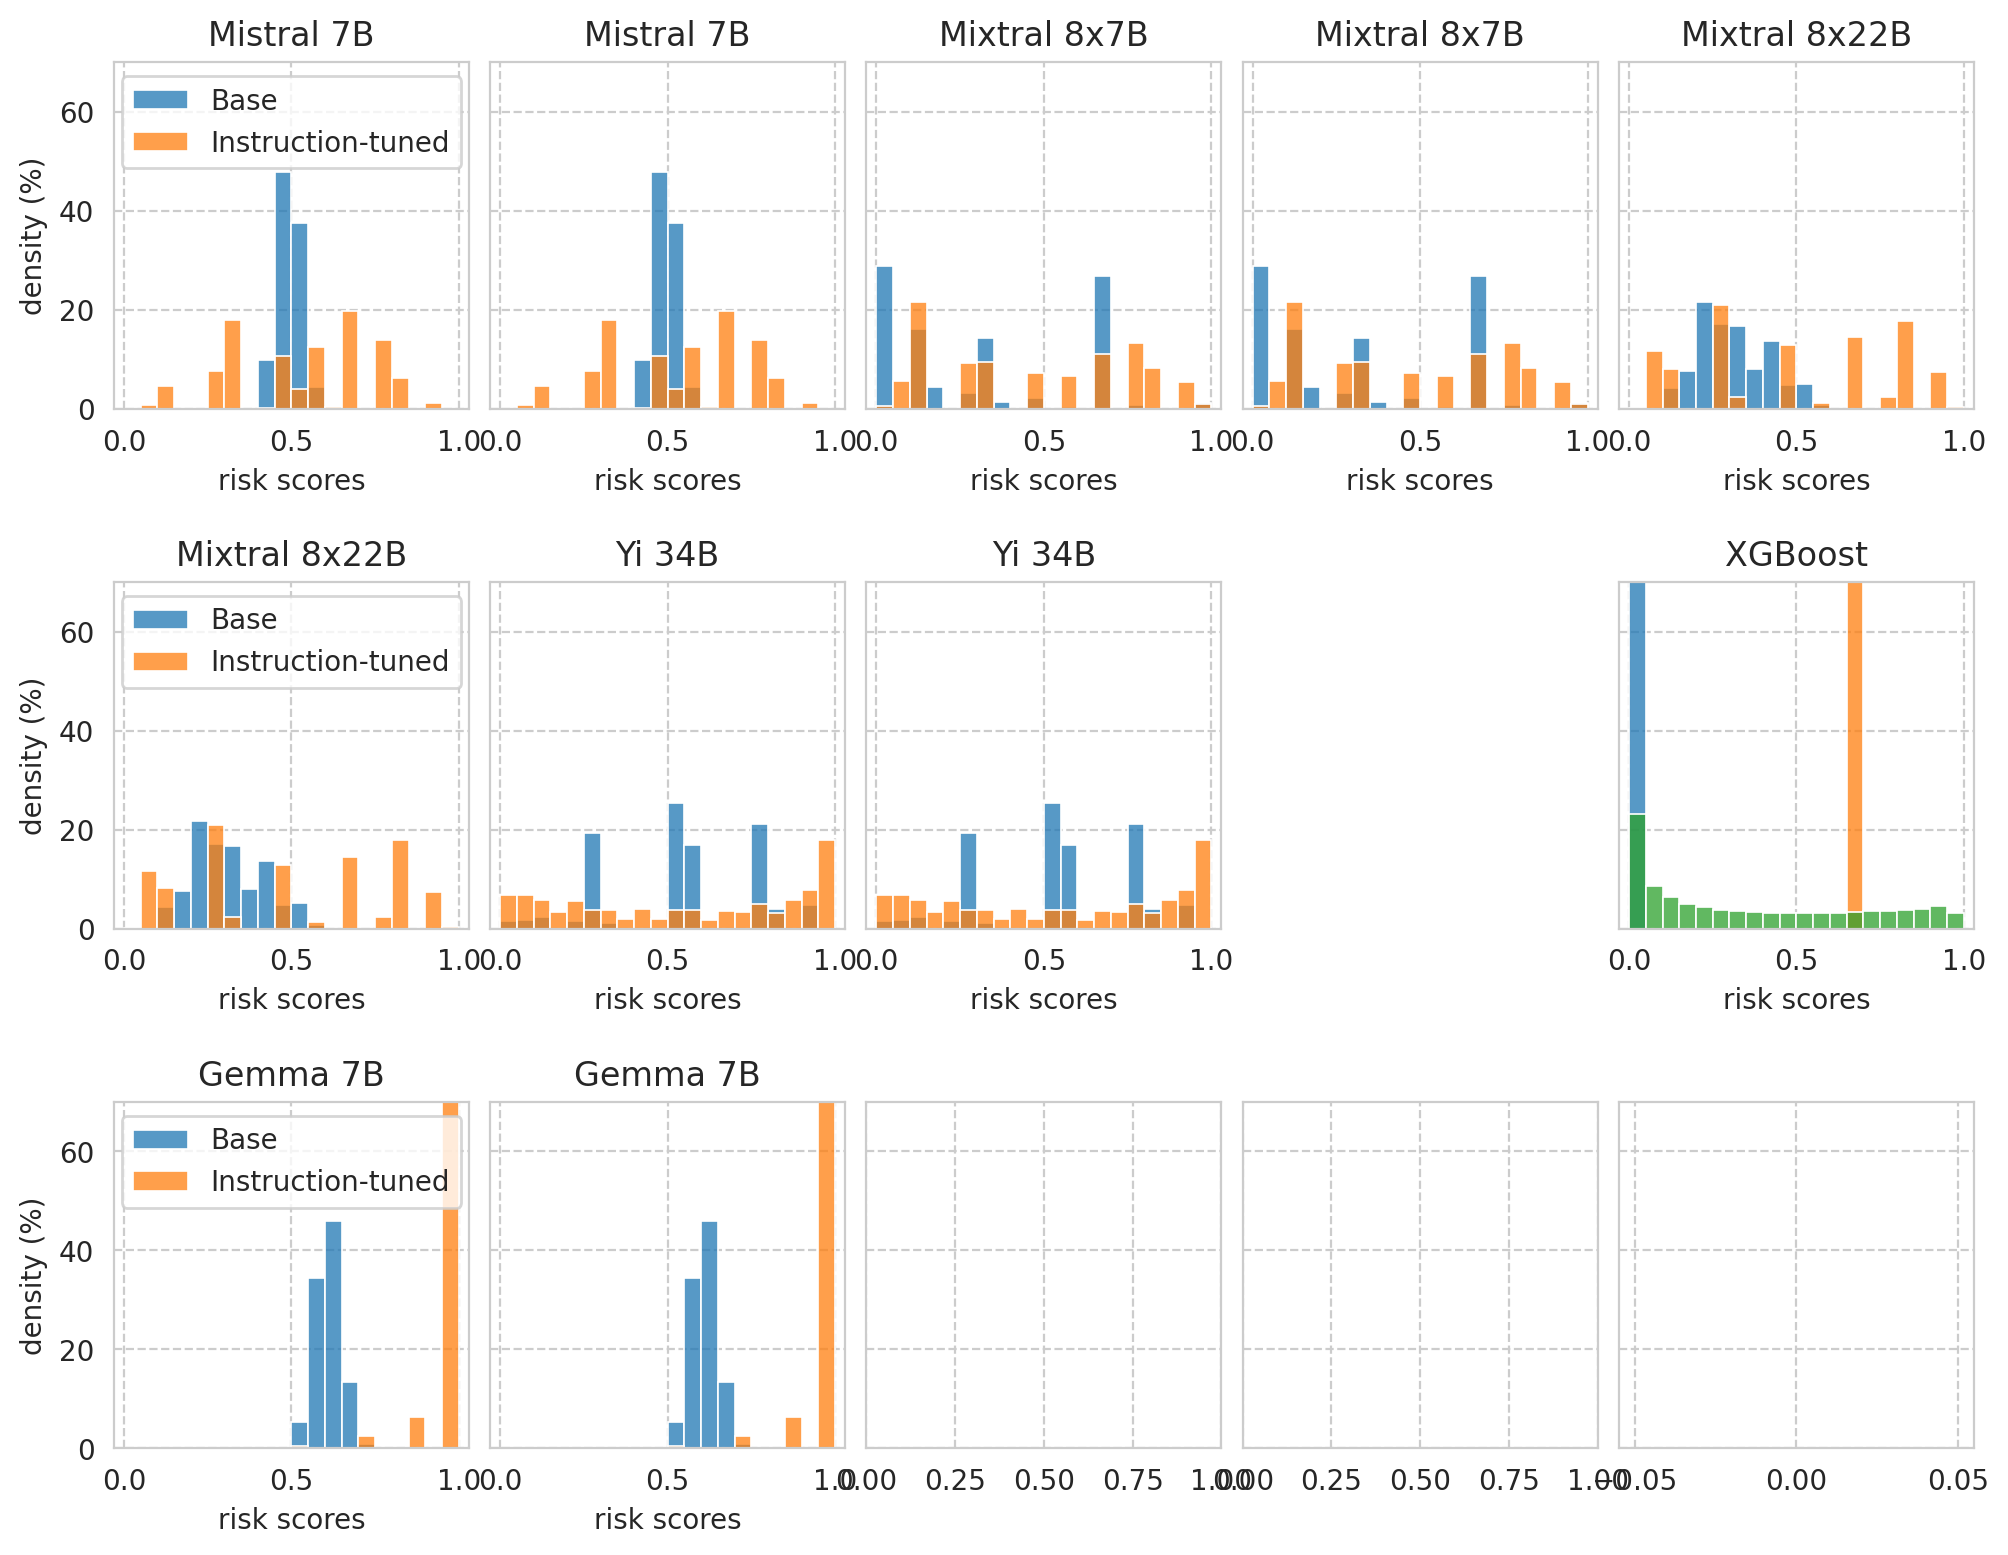

In [64]:
PLOT_THRESHOLD_LINE = False

N_PLOTS = len(model_pairs) + 1  # plus 1 for the XGBoost baseline

N_COLS = 5
N_ROWS = math.ceil(N_PLOTS / N_COLS)

fig, axes = plt.subplots(
    nrows=N_ROWS, ncols=N_COLS,
    figsize=(12, 3 * N_ROWS),
    sharey=True, sharex=False,
    gridspec_kw=dict(
        hspace=0.5,
        wspace=0.06,
    ),
)

# Plot settings
plot_config = dict(
    bins=N_BINS,
    binrange=(0, 1),
    stat="percent",
)

# Plot score distribution for model pairs
for idx, (base_name, instr_name) in enumerate(model_pairs):
    ax_row = idx // N_COLS
    ax_col = idx % N_COLS

    ax = axes[ax_row, ax_col]
    base_row = task_df[task_df[model_col] == base_name].iloc[0]
    it_row = task_df[task_df[model_col] == instr_name].iloc[0]

    # Get scores
    base_scores = scores_df_map[base_row.name]["risk_score"]
    it_scores = scores_df_map[it_row.name]["risk_score"]

    ax.set_title(base_row["name"])

    ax.set_xlabel("risk scores")
    if ax_col == 0:
        ax.set_ylabel("density (%)")

    if ax_row == 0:
        ax.set_ylim(0, 70)

    ax.set_xlim(-0.03, 1.03)

    # Render plot
    sns.histplot(base_scores, label="Base", ax=ax, **plot_config)
    sns.histplot(it_scores, label="Instruction-tuned", ax=ax, **plot_config)

    # Draw faint vertical line with t^* of each model
    threshold_col = "optimal_thresh"
    # threshold_col = "fit_thresh_on_100"

    if PLOT_THRESHOLD_LINE:
        ax.axvline(x=base_row[threshold_col], ls="--", color=palette[0], alpha=0.5)
        ax.axvline(x=it_row[threshold_col], ls="--", color=palette[1], alpha=0.5)

    # Render legend on left-most plots
    if ax_col == 0:
        ax.legend(loc="upper center")

        if PLOT_THRESHOLD_LINE:
            ax.text(
                x=base_row[threshold_col] - 5e-2,
                y=43,
                s="$t^*$",
                color=palette[0],
                fontsize=10,
                ha='center',
                va='bottom',
                # zorder=-1,
            ) #.set_bbox(dict(facecolor='white', alpha=0.5))
            
            ax.text(
                x=it_row[threshold_col] + 5e-2,
                y=43,
                s="$t^*$",
                color=palette[1],
                fontsize=10,
                ha='center',
                va='bottom',
                # zorder=-1,
            )
        

# Plot score distribution for XGBoost baseline
for idx, baseline_name in enumerate(["LR", "XGBoost"]):
    ax = axes[1, 3 + idx]
    ax.set_title(baseline_name)
    
    baseline_row = task_df[task_df["name"] == baseline_name].iloc[0]
    xgboost_scores = scores_df_map[baseline_row.name]["risk_score"]
    
    sns.histplot(
        xgboost_scores,
        label=baseline_name,
        color=palette[2],
        ax=ax,
        **plot_config,
    )

    ax.set_xlabel("risk scores")

# Remove LR?
axes[1, 3].remove()

axes[1, 4].set_ylabel("density (%)")
axes[1, 4].set_yticks([0, 20, 40, 60])
axes[1, 4].set_yticklabels([0, 20, 40, 60])

plt.plot()

# Save figure
save_fig(fig, f"score-distribution" + ("_with-threshold" if PLOT_THRESHOLD_LINE else ""))

## Calibration curves

Base models vs Instruction-tuned models:

In [65]:
TASK = "ACSIncome"

df = results_df[results_df[task_col] == TASK]
print(f"{len(df)=}")

len(df)=27


In [66]:
from sklearn.calibration import CalibrationDisplay

base_models_to_plot = [m for m in df["base_name"].unique() if "gemma" not in m.lower()]

base_models_to_plot = [
    "Meta-Llama-3-8B",
    "Meta-Llama-3-70B",
    "Mistral-7B-v0.1",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    # "Yi-34B",
]

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), gridspec_kw=dict(wspace=0.33), sharey=False)

# Plot base models
for ax, model_list in zip(axes, (base_models_to_plot, instr_models_to_plot)):
    
    for idx, m in enumerate(model_list):

        curr_row = df[df[model_col] == m].iloc[0]
        curr_scores = scores_df_map[curr_row.name]

        disp = CalibrationDisplay.from_predictions(
            y_true=curr_scores["label"],
            y_prob=curr_scores["risk_score"],
            n_bins=10,
            strategy="quantile",
            name=curr_row["name"],
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
        )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

ylabel = "Fraction of positives " + r"$\left(\mathrm{P}[Y=1]\right)$"
axes[0].set_ylabel(ylabel)
axes[1].set_ylabel(ylabel)

xlabel = "Mean predicted probability" # + r" $(\mathbb{E}[R])$"
axes[0].set_xlabel(xlabel)
axes[1].set_xlabel(xlabel)

axes[0].set_title("Base models")
axes[1].set_title("Instruction-tuned models")

axes[1].legend().remove()

# Legent to the right of the right-most plot
axes[0].legend(loc="upper right", bbox_to_anchor=(3.15, 1))


plt.plot()

save_fig(fig, f"calibration-curves-base-and-instr.pdf")

IndexError: single positional indexer is out-of-bounds

### Per sub-group
Plot calibration curves per race sub-group, for each model pair.

In [ ]:
%%time
acs_dataset = ACSDataset.make_from_task(task=TASK, cache_dir=DATA_DIR)

Plot:

In [ ]:
# Omit small groups from the plots (results can be too noisy)
OMIT_GROUPS_BELOW_PCT = 4
N_BINS = 10

In [ ]:
sens_attr_col = "RAC1P"
sens_attr_map = {
    1: "White",
    2: "Black",
    6: "Asian",
    # 8: "Other",   # some other race alone
}

name_to_sens_attr_map = {val: key for key, val in sens_attr_map.items()}

def plot_cali_curve(model_id, ax, df):
    """Plot sub-group calibration curves using sklearn"""

    curr_row = df.loc[model_id]
    curr_scores_df = scores_df_map[curr_row.name]

    y_true = curr_scores_df["label"].to_numpy()
    y_scores = curr_scores_df["risk_score"].to_numpy()

    sens_attr = acs_dataset.data.loc[curr_scores_df.index][sens_attr_col].to_numpy()

    for idx, group_val in enumerate(np.unique(sens_attr)):
        group_filter = sens_attr == group_val

        if np.sum(group_filter) < len(group_filter) * 0.01 * OMIT_GROUPS_BELOW_PCT:
            # print(f"Skipping group={group_val}")
            continue

        disp = CalibrationDisplay.from_predictions(
            y_true=y_true[group_filter],
            y_prob=y_scores[group_filter],
            n_bins=N_BINS,
            # strategy="uniform",
            strategy="quantile",
            name=str(sens_attr_map.get(group_val, group_val)),
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
        )

    # Set other plot settings
    ax.set_title(curr_row["name"])
    return disp

In [ ]:
from folktexts.evaluation import bootstrap_estimate

def plot_cali_curve_ci(model_id, ax, df, ci=95):
    """Plot sub-group calibration curves with bootstrap confidence intervals"""

    curr_row = df.loc[model_id]
    curr_scores_df = scores_df_map[curr_row.name]

    y_true = curr_scores_df["label"].to_numpy()
    y_scores = curr_scores_df["risk_score"].to_numpy()

    sens_attr = acs_dataset.data.loc[curr_scores_df.index][sens_attr_col].to_numpy()

    # Compute bins
    y_scores_binned, bin_edges = pd.qcut(y_scores, q=N_BINS, retbins=True, duplicates="drop")
    bin_names = y_scores_binned.categories   # Name used for each bin: "(bin_low_range, bin_high_range)"

    # To hold plot render artifacts
    plot_artifacts = {}

    for idx, group_val in enumerate(np.unique(sens_attr)):
        group_filter = sens_attr == group_val

        if np.sum(group_filter) < len(group_filter) * 0.01 * OMIT_GROUPS_BELOW_PCT:
            # print(f"Skipping group={group_val}")
            continue

        group_labels = y_true[group_filter]
        group_scores = y_scores[group_filter]

        group_cali_points = []
        for b in bin_names:
            bin_filter = y_scores_binned == b

            group_labels_current_bin = y_true[group_filter & bin_filter]
            group_scores_current_bin = y_scores[group_filter & bin_filter]

            results = bootstrap_estimate(
                eval_func=lambda labels, scores, sensattr: {
                    "mean_score": np.mean(scores),
                    "mean_label": np.mean(labels),
                },
                y_true=group_labels_current_bin,
                y_pred_scores=group_scores_current_bin,
                sensitive_attribute=None,
            )

            # Store plot point for this bin
            group_cali_points.append((
                results["mean_score_mean"],    # x coordinate
                results["mean_label_mean"],    # y coordinate
                (                              # y coordinate c.i. range
                    results["mean_label_low-percentile"],
                    results["mean_label_high-percentile"],
                ),
            ))

        # Get group label from sensitive attribute map
        group_label = str(sens_attr_map.get(group_val, group_val))
        
        # Plot this group's calibration curve w/ conf. intervals!
        line, caps, bars = ax.errorbar(
            # x=[mean_score for mean_score, *_ in group_cali_points],
            x=[(bin_edges[idx-1] + bin_edges[idx]) / 2. for idx in range(1, len(bin_edges))],
            y=[mean_label for _, mean_label, _ in group_cali_points],
            yerr=np.hstack(
                [
                    np.abs(np.array(yerr_range).reshape(2, 1) - y)
                    for _x, y, yerr_range in group_cali_points]
            ),
            fmt="o", markersize=1,
            linestyle=["-.", "-", "--"][idx % 3],
            linewidth=2,
            label=group_label,
        )
        plot_artifacts[group_label] = (line, caps, bars)

    # Global plot settings
    ax.plot(
        [0,1], [0,1],
        ls="dotted", color="black",
        label="Perfectly calibrated",
    )

    # Draw custom legend
    handles = []
    for group, (l, c, b) in plot_artifacts.items():
        l.set_label(group)
        l.set_markersize(0)
        handles.append(l)

    # Perfectly calibrated line
    perf_cal_line = plt.Line2D([], [], ls=":", color="black", label="Perfectly calibrated")

    # Confidence interv. marker line
    conf_int_line = plt.Line2D([], [], lw=0, ms=10, marker="|", markeredgewidth=2, color="grey", label="$95\%$ conf. int.")
    
    ax.legend(handles=handles + [conf_int_line, perf_cal_line])
    ax.set_title(curr_row["name"])

    return disp

### Plot sub-group calibration (with confidence intervals)

In [ ]:
from sklearn.calibration import CalibrationDisplay

# Get results for the current task
task_df = results_df[results_df[task_col] == TASK]

# Get all base/instruct model pairs
base_models_to_plot = task_df["base_name"].unique().tolist()

instr_models_to_plot = [
    task_df[
        (task_df["base_name"] == m)
        & (task_df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

base_it_pairs = list(zip(base_models_to_plot, instr_models_to_plot))

for base_model, it_model in tqdm(base_it_pairs):
    fig, axes = plt.subplots(ncols=2, figsize=(7, 2.8), gridspec_kw=dict(wspace=0.35), sharey=False)

    for idx, ax, m in zip(range(len(axes)), axes, (base_model, it_model)):

        curr_row = task_df[(task_df[model_col] == m) & (task_df["uses_all_features"])].iloc[0]
        curr_id = curr_row.name

        # # Original sklearn calibration plot:
        # plot_cali_curve(curr_id, ax=ax, df=task_df)

        # # Plot with confidence intervals:
        plot_cali_curve_ci(curr_id, ax=ax, df=task_df)
        
        # Remove left plot legend
        if idx == 0:
            ax.get_legend().remove()
        else:
            ax.get_legend().set(loc="upper left", bbox_to_anchor=(1.1, 1))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_xlabel("Mean risk score")
        ax.set_ylabel("Fraction of positives")

    plt.plot()
    save_fig(fig, f"calibration-curves-per-subgroup.{base_model}.pdf")


## Score distribution per sub-group

In [ ]:
sens_attr_data = acs_dataset.data[sens_attr_col]
sens_attr_data.head(3)

In [ ]:
# Plot settings
plot_config = dict(
    bins=20,
    binrange=(0, 1),
    stat="percent",
)

for base_model, it_model in tqdm(base_it_pairs):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3), gridspec_kw=dict(wspace=0.33), sharey=False)

    for idx, ax, m in zip(range(len(axes)), axes, (base_model, it_model)):

        model_row = task_df[(task_df[model_col] == m) & (task_df["uses_all_features"])].iloc[0]
        model_id = model_row.name

        scores_df = scores_df_map[model_id]
        scores_df["group"] = sens_attr_data.loc[scores_df.index]

        # sns.histplot(
        #     data=scores_df,
        #     x="risk_score",
        #     hue="group",
        #     ax=ax,
        #     **plot_config,
        # )

        for group_val, group_name in sens_attr_map.items():
            group_scores_df = scores_df[sens_attr_data.loc[scores_df.index] == group_val]
            sns.histplot(
                group_scores_df["risk_score"],
                label=group_name,
                ax=ax,
                alpha=0.5,
                **plot_config,
            )

        # Remove left plot legend
        if idx == 0:
            ax.legend(loc="upper left")

        ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)

        ax.set_title(model_row["name"])

    plt.plot()
    save_fig(fig, f"score-per-subgroup.{base_model}.pdf")


## Compute mean under-/over-estimation of risk score
It's basocally akin to computing ECE without the absolute...

In [ ]:
def compute_confidence_bias_metric_helper(data):
    """Helper to compute the under- / over-confidence metric.
    """
    mean_label = data["label"].mean()
    mean_score = data["risk_score"].mean()

    if mean_score < 0.5:
        return ((1 - mean_score) - (1 - mean_label))
    else:
        return (mean_score - mean_label)

def compute_confidence_bias_metric(model_id, quantiled_bins=False, scores_df=None):
    if scores_df is None:
        scores_df = scores_df_map[model_id]

    discretization_func = pd.qcut if quantiled_bins else pd.cut
    scores_df["score_bin"] = discretization_func(scores_df["risk_score"], 10, labels=range(10))
    
    return (1 / len(scores_df)) * sum(
        len(bin_data) * compute_confidence_bias_metric_helper(bin_data)
        for bin_ in range(10)
        if len(bin_data := scores_df[scores_df["score_bin"] == bin_]) > 0
    )

In [ ]:
confidence_scores = {
    m: compute_confidence_bias_metric(m)
    for m in tqdm(scores_df_map.keys())
}

In [ ]:
results_df["under_over_score"] = results_df.apply(lambda row: confidence_scores[row.name], axis=1)
results_df.sort_values("under_over_score", ascending=True)["under_over_score"]

In [ ]:
TASK = "ACSIncome"
# TASK = "ACSTravelTime"
# TASK = "ACSMobility"
# TASK = "ACSEmployment"

In [ ]:
plot_df = results_df[results_df[task_col] == TASK]
# plot_df = plot_df.drop(index=[id_ for id_ in plot_df.index if "gemma" in id_.lower() or "yi" in id_.lower()])   # omit Gemma models bc they're garbage :)

fig, ax = plt.subplots(figsize=(4, 3))
sns.barplot(
    data=plot_df.sort_values("under_over_score", ascending=True),
    x="under_over_score",
    y="name",
    # y=task_col,
    hue="is_inst",
    ax=ax,
)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Base", "Instruct"])

plt.ylabel("")
plt.xlabel(r"$\mathrm{R}_\mathrm{bias}$")

plt.title(f"Risk score confidence bias")

save_fig(fig, f"under_over_score.{TASK}.pdf")

## Compute risk score fairness per sub-group

In [ ]:
sens_attr_data = acs_dataset.data[sens_attr_col]
sens_attr_data.head(3)

In [ ]:
def compute_signed_score_bias(scores_df, quantiled_bins=False, n_bins=10):
    discretization_func = pd.qcut if quantiled_bins else pd.cut
    scores_df["score_bin"] = discretization_func(scores_df["risk_score"], n_bins, duplicates="drop", retbins=False)
    bin_categories = scores_df["score_bin"].dtype.categories

    return (1 / len(scores_df)) * sum(
        len(bin_data) * (bin_data["risk_score"].mean() - bin_data["label"].mean())
        for bin_ in bin_categories
        if len(bin_data := scores_df[scores_df["score_bin"] == bin_]) > 0
    )

In [ ]:
def compute_signed_subgroup_score_bias(model, group: int | str) -> float:
    scores_df = scores_df_map[model]
    if isinstance(group, str):
        group = name_to_sens_attr_map[group]

    scores_df = scores_df[sens_attr_data.loc[scores_df.index] == group]
    # return compute_confidence_metric(model, scores_df=scores_df)
    return compute_signed_score_bias(scores_df)


def compute_calibration_fairness(model: str, priv_group: int | str, unpriv_group: int | str) -> float:
    return (
        compute_signed_subgroup_score_bias(model, group=priv_group)
        - compute_signed_subgroup_score_bias(model, group=unpriv_group)
    )

In [ ]:
calibration_per_subgroup_df = pd.DataFrame([
    pd.Series(
        {
            f"{group}_score_bias": compute_signed_subgroup_score_bias(model_id, group)
            for group in sens_attr_map.values()
        },
        name=model_id,
    )
    for model_id in task_df.index
])

calibration_per_subgroup_df["White_v_Black_score_bias"] = \
    calibration_per_subgroup_df["White_score_bias"] - calibration_per_subgroup_df["Black_score_bias"]

calibration_per_subgroup_df["White_v_Asian_score_bias"] = \
    calibration_per_subgroup_df["White_score_bias"] - calibration_per_subgroup_df["Asian_score_bias"]

calibration_per_subgroup_df["Asian_v_Black_score_bias"] = \
    calibration_per_subgroup_df["Asian_score_bias"] - calibration_per_subgroup_df["Black_score_bias"]

calibration_per_subgroup_df.sample(3)

**Note:** This is an example of comparing risk score bias between different sub-groups. A more detailed analysis must be conducted to draw any sort of conclusions regarding prediction fairness of the LLM.

In [ ]:
GROUP_A = "Asian"
# GROUP_A = "White"
GROUP_B = "Black"
# GROUP_B = "Asian"

COLUMN = f"{GROUP_A}_v_{GROUP_B}_score_bias"

plot_df = calibration_per_subgroup_df.join(results_df, how="left", validate="1:1")
plot_df = plot_df.drop(index=[id_ for id_ in plot_df.index if "gemma" in id_.lower()])   # omit Gemma models bc they're garbage :)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data=plot_df.sort_values(COLUMN, ascending=True),
    x=COLUMN,
    y="name",
    hue="is_inst",
    ax=ax,
)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Base", "Instruct"])

plt.ylabel("")
plt.xlabel("$\Delta_{SCE}$")

plt.title(
    "Signed risk score bias\n"
    + r"($SCE_{" + GROUP_A
    + r"} - SCE_{" + GROUP_B
    + r"}$)"
)

plt.plot()

save_fig(fig, f"score_bias.{COLUMN}.pdf")

In [ ]:
plot_df.sort_values(COLUMN, ascending=False).head(3)

---